In [1827]:
import numpy as np
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random

In [1828]:
w = 0.1
kp = 0.8
kv = 0.6
kp0 = 0.2
kv0 = 0.7
N = 400 #number of agents
Im = 0.13
m = 10.1

#parameters for state space model(input matrix)
A = np.empty([N,N])
for i in range(0,N):
    for j in range(0,N):
        if j == i:
            A[i,j] = -4*w*kp-kp0
        elif j in range(i-2,i+3):
            A[i,j] = w*kp
        else:
            A[i,j] = 0
A[0,0] = -2*w*kp-kp0
A[1,1] = -3*w*kp-kp0
A[N-2,N-2] = -3*w*kp-kp0
A[N-1,N-1] = -2*w*kp-kp0

B = np.empty([N,N])
for i in range(0,N):
    for j in range(0,N):
        if j == i:
            B[i,j] = -4*w*kv-kv0
        elif j in range(i-2,i+3):
            B[i,j] = w*kv
        else:
            B[i,j] = 0
B[0,0] = -2*w*kv-kv0
B[1,1] = -3*w*kv-kv0
B[N-2,N-2] = -3*w*kv-kv0
B[N-1,N-1] = -2*w*kv-kv0

In [1829]:
#matrix for leader information

L1 = np.zeros(N)
L2 = kv0*np.ones(N)
L = np.append(L1,L1)
L = np.append(L,L2)
L = np.append(L,L1)

LL = np.append(L1,L1)
LL = np.append(LL,L1)
LL = np.append(LL,L2)

In [1830]:
#matrix for internal state
Z = np.zeros([N,N])
I = np.eye(N)
R1 = np.append(Z,Z,axis=1)
R1 = np.append(R1,I,axis=1)
R1 = np.append(R1,Z,axis=1)

R2 = np.append(Z,Z,axis=1)
R2 = np.append(R2,Z,axis=1)
R2 = np.append(R2,I,axis=1)

R3 = np.append(A,Z,axis=1)
R3 = np.append(R3,B,axis=1)
R3 = np.append(R3,Z,axis=1)

R4 = np.append(Z,A,axis=1)
R4 = np.append(R4,Z,axis=1)
R4 = np.append(R4,B,axis=1)

R = np.append(R1,R2,axis=0)
R = np.append(R,R3,axis=0)
R = np.append(R,R4,axis=0)


In [1831]:
#dynamics of leader
l = 0.12 #hand position 
tn = 401 #time points
omega = np.pi/80
v = np.pi/8
dyldt = np.empty(5)
yl0 = np.array([0, l, l*omega, v, np.pi/2])
t = np.linspace(0,160,tn)


def modelleader1(yl,t):
    dyldt[0] = yl[2]
    dyldt[1] = yl[3]
    dyldt[2] = -v*np.sign(yl[0]-10)*omega*np.sin(yl[4])-l*np.sign(yl[0]-10)*omega**2*np.cos(yl[4])
    dyldt[3] = v*np.sign(yl[0]-10)*omega*np.cos(yl[4])-l*np.sign(yl[0]-10)*omega**2*np.sin(yl[4])
    dyldt[4] = np.sign(yl[0]-10)*omega
    return dyldt
yl = odeint(modelleader1, yl0, t)


In [1832]:
#define the disturbance acting to agents
d11 = np.zeros([tn,N])
d22 = np.zeros([tn,N])
for i in range(0,N):
    d11[:,i] = np.random.rand(1)*2*np.sin(0.5*t)*np.exp(-0.02*t)#+np.pi*2*np.ones(tn)*np.random.rand(1)  np.random.rand(1)*
    d22[:,i] = np.random.rand(1)*2*np.sin(0.5*t)*np.exp(-0.02*t)#np.random.rand(1)*

In [1833]:
#dynamics of leader(without maneuver)
l = 0.12 #hand position 
tn = 401 #time points
omega = np.pi/40
v = np.pi/4
theta = np.pi/4
dylldt = np.empty(5)
yll0 = np.array([l*np.cos(theta), l*np.sin(theta), v*np.cos(theta), v*np.sin(theta), theta])


def modelleader2(yll,t):
    dyldt[0] = yll[2]
    dyldt[1] = yll[3]
    dyldt[2] = 0
    dyldt[3] = 0
    dyldt[4] = 0
    return dylldt

yll = odeint(modelleader2, yll0, t)


In [1834]:
#desired dynamics
delta = np.empty([N,2])
for i in range(0,N):
    delta[i,0] = 5*((-1)**(i+1))
    delta[i,1] = -5*((i+2)//2)

# desired handposition of followers
ydd = np.zeros([tn,4*N])
for i in range(0,tn):
    for j in range(0,N):
        ydd[i,j] = delta[j,0] + yl[i,0]
    for j in range(N,2*N):
        ydd[i,j] = delta[j-N,1] + yl[i,1] 
        
        
# matrix for desired state
D = np.zeros([N,N])
for i in range(2,N-2):
    D[i,i] = 4*w*kp
    D[i,i-2] = -w*kp
    D[i,i-1] = -w*kp
    D[i,i+2] = -w*kp
    D[i,i+1] = -w*kp
D[1,1] = 2*w*kp
D[2,2] = 3*w*kp
D[N-1,N-1] = 2*w*kp
D[N-2,N-2] = 3*w*kp

D = np.zeros([N,N+4])
for i in range(0,N):
    D[i,i+2] = 4*w*kp
    D[i,i] = -w*kp
    D[i,i+1] = -w*kp
    D[i,i+3] = -w*kp
    D[i,i+4] = -w*kp
D = D[:,2:N+2]


In [1835]:
# parameters for state model(leader + distance)
DELTA1 = np.empty(N)
DELTA2 = np.empty(N)
for i in range(2,N-2):
    DELTA1[i] = 4*w*kp*delta[i,0] + kp0*delta[i,0] - w*kp*delta[i-2,0] - w*kp*delta[i-1,0] - w*kp*delta[i+1,0] - w*kp*delta[i+2,0]
DELTA1[0] = 2*w*kp*delta[0,0] + kp0*delta[0,0] - w*kp*delta[1,0] - w*kp*delta[2,0]
DELTA1[1] = 3*w*kp*delta[1,0] + kp0*delta[1,0] - w*kp*delta[2,0] - w*kp*delta[3,0] - w*kp*delta[0,0]
DELTA1[N-1] = 2*w*kp*delta[N-1,0] + kp0*delta[N-1,0] - w*kp*delta[N-2,0] - w*kp*delta[N-3,0]
DELTA1[N-2] = 3*w*kp*delta[N-2,0] + kp0*delta[N-2,0] - w*kp*delta[N-1,0] - w*kp*delta[N-3,0] - w*kp*delta[N-4,0]

for i in range(2,N-2):
    DELTA2[i] = 4*w*kp*delta[i,1] + kp0*delta[i,1] - w*kp*delta[i-2,1] - w*kp*delta[i-1,1] - w*kp*delta[i+1,1] - w*kp*delta[i+2,1]
DELTA2[0] = 2*w*kp*delta[0,1] + kp0*delta[0,1] - w*kp*delta[1,1] - w*kp*delta[2,1]
DELTA2[1] = 3*w*kp*delta[1,1] + kp0*delta[1,1] - w*kp*delta[2,1] - w*kp*delta[3,1] - w*kp*delta[0,1]
DELTA2[N-1] = 2*w*kp*delta[N-1,1] + kp0*delta[N-1,1] - w*kp*delta[N-2,1] - w*kp*delta[N-3,1]
DELTA2[N-2] = 3*w*kp*delta[N-2,1] + kp0*delta[N-2,1] - w*kp*delta[N-1,1] - w*kp*delta[N-3,1] - w*kp*delta[N-4,1]
KP0 = kp0*np.ones(N)
KV0 = kv0*np.ones(N)
DELTA = np.append(np.zeros(2*N),DELTA1)
DELTA = np.append(DELTA,DELTA2)


In [1836]:
def modelnodis(y,t,yl):#no disturbance

    ZZ = np.zeros(N)

    X0 = np.append(ZZ,ZZ)
    X0 = np.append(X0,KP0*yl[0]+KV0*yl[2])
    X0 = np.append(X0,KP0*yl[1]+KV0*yl[3])
    
    
    dydt = np.empty(5*N)
    dydt[:4*N] = np.dot(R,y[:4*N]) + DELTA + X0
    dydt[4*N:] = -(1/(2*l))*y[2*N:3*N]*np.sin(y[4*N:])+(1/(2*l))*y[3*N:4*N]*np.cos(y[4*N:])
    
    return dydt

In [1837]:
y00 = np.append(delta[:,0],l*np.ones(N)+delta[:,1])
y00 = np.append(y00,np.ones(N)*l*omega)
y00 = np.append(y00,v*np.ones(N))
y00 = np.append(y00,np.ones(N)*np.pi/2)
y0 = y00
ys = np.empty([5*N,tn])
ys[:,0] = y0

for i in range(1,tn):
    tspan = [t[i-1],t[i]]
    y = odeint(modelnodis,y0,tspan,args=(yl[i,:],))
    y0 = y[1,:]
    ys[:,i] = y[1,:]#state without disturbance

In [1838]:
def modelwithdis(yy,t,yll,d11,d22):
    ZZ = np.zeros(N)   
    X0 = np.append(ZZ,ZZ)
    X0 = np.append(X0,KP0*yll[0]+KV0*yll[2])
    X0 = np.append(X0,KP0*yll[1]+KV0*yll[3])
    
    C = np.zeros(4*N)#disturbance
    Cc1 = np.zeros([N,2])
    for i in range(0,np.int(N/2)):#np.int(N/2) for formation with 4 followers, change to 1
        Cc1[i,0] = (1/m)*np.cos(yy[4*N+i])
        Cc1[i,1] = (-l/Im)*np.sin(yy[4*N+i])
    Cc2 = np.zeros([N,2])
    for i in range(0,np.int(N/2)):#np.int(N/2) for formation with 4 followers, change to 1
        Cc2[i,0] = (1/m)*np.sin(yy[4*N+i])
        Cc2[i,1] = (l/Im)*np.cos(yy[4*N+i])
    dis = np.empty(2*N) 
    for i in range(0,N):
        dis[i] = Cc1[i,0]*d11[i] + Cc1[i,1]*d22[i] 
        dis[N+i] = Cc2[i,0]*d11[i] + Cc2[i,1]*d22[i] 
    C[2*N:4*N] = dis
    
    dydt = np.empty(5*N)
    dydt[:4*N] = np.dot(R,yy[:4*N]) + DELTA + X0 + C
    dydt[4*N:] = -(1/(2*l))*yy[2*N:3*N]*np.sin(yy[4*N:])+(1/(2*l))*yy[3*N:4*N]*np.cos(yy[4*N:])
    
    return dydt

In [1839]:
yss = np.empty([5*N,tn])
yss[:,0] = y00
for i in range(1,tn):
    tspan = [t[i-1],t[i]]
    yy = odeint(modelwithdis,y00,tspan,args=(yl[i,:],d11[i,:],d22[i,:]))
    y00 = yy[1,:]
    yss[:,i] = yy[1,:]#actual state

In [1840]:
e = np.empty([N,tn])
for i in range(2,N-2):
    e[i,:] = -(w*kp*((yss[i,:]-yss[i-2,:])-(delta[i,0]-delta[i-2,0]))+w*kp*((yss[i,:]-yss[i-1,:])-(delta[i,0]-delta[i-1,0])) \
    +w*kp*((yss[i,:]-yss[i+1,:])-(delta[i,0]-delta[i+1,0]))+w*kp*((yss[i,:]-yss[i+2,:])-(delta[i,0]-delta[i+2,0])))
e[0,:] = -(w*kp*((yss[0,:]-yss[1,:])-(delta[0,0]-delta[1,0]))+w*kp*((yss[0,:]-yss[2,:])-(delta[0,0]-delta[2,0])))
e[1,:] = -(w*kp*((yss[1,:]-yss[0,:])-(delta[1,0]-delta[0,0])) \
    +w*kp*((yss[1,:]-yss[2,:])-(delta[1,0]-delta[2,0]))+w*kp*((yss[1,:]-yss[3,:])-(delta[1,0]-delta[3,0])))
e[N-2,:] = -(w*kp*((yss[N-2,:]-yss[N-2-2,:])-(delta[N-2,0]-delta[N-2-2,0]))+w*kp*((yss[N-2,:]-yss[N-2-1,:])-(delta[N-2,0]-delta[N-2-1,0])) \
    +w*kp*((yss[N-2,:]-yss[N-2+1,:])-(delta[N-2,0]-delta[N-2+1,0])))
e[N-1,:] = -(w*kp*((yss[N-1,:]-yss[N-1-2,:])-(delta[N-1,0]-delta[N-1-2,0]))+w*kp*((yss[N-1,:]-yss[N-1-1,:])-(delta[N-1,0]-delta[N-1-1,0])))

In [1841]:
el = np.empty([N,tn])
etotal = np.empty([N,tn])
for i in range(0,N):
    el[i,:] = -kp0*(yss[i,:]-ys[i,:])
    etotal[i,:] = e[i,:]+el[i,:]

In [1842]:
e2 = np.empty([N,tn])
for i in range(2,N-2):
    e2[i,:] = -(w*kp*((yss[i+N,:]-yss[N+i-2,:])-(delta[i,1]-delta[i-2,1]))+w*kp*((yss[N+i,:]-yss[N+i-1,:])-(delta[i,1]-delta[i-1,1])) \
    +w*kp*((yss[N+i,:]-yss[N+i+1,:])-(delta[i,1]-delta[i+1,1]))+w*kp*((yss[N+i,:]-yss[N+i+2,:])-(delta[i,1]-delta[i+2,1])))
e2[0,:] = -(w*kp*((yss[N+0,:]-yss[N+1,:])-(delta[0,1]-delta[1,1]))+w*kp*((yss[N+0,:]-yss[N+2,:])-(delta[0,1]-delta[2,1])))
e2[1,:] = -(w*kp*((yss[N+1,:]-yss[N+0,:])-(delta[1,1]-delta[0,1])) \
    +w*kp*((yss[N+1,:]-yss[N+2,:])-(delta[1,1]-delta[2,1]))+w*kp*((yss[N+1,:]-yss[N+3,:])-(delta[1,1]-delta[3,1])))
e2[N-2,:] = -(w*kp*((yss[N+N-2,:]-yss[N+N-2-2,:])-(delta[N-2,1]-delta[N-2-2,1]))+w*kp*((yss[N+N-2,:]-yss[N+N-2-1,:])-(delta[N-2,1]-delta[N-2-1,1])) \
    +w*kp*((yss[N+N-2,:]-yss[N+N-2+1,:])-(delta[N-2,1]-delta[N-2+1,1])))
e2[N-1,:] = -(w*kp*((yss[N+N-1,:]-yss[N+N-1-2,:])-(delta[N-1,1]-delta[N-1-2,1]))+w*kp*((yss[N+N-1,:]-yss[N+N-1-1,:])-(delta[N-1,1]-delta[N-1-1,1])))

el2 = np.empty([N,tn])
etotal2 = np.empty([N,tn])
for i in range(0,N):
    el2[i,:] = -kp0*(yss[N+i,:]-ys[N+i,:])
    etotal2[i,:] = e2[i,:]+el2[i,:]

In [1843]:
font1 = {'size':'24'}
font2 = {'size':'15'}
font3 = {'size':'10'}

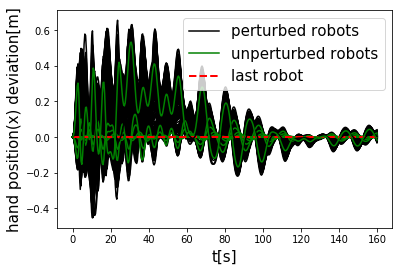

In [1844]:
for i in range(0,np.int(N/2)):#np.int(N/2) for formation with 4 followers, change to 1
    plt.plot(t[:],etotal[i,:],'k-')
for i in range(np.int(N/2),N):#np.int(N/2) for formation with 4 followers, change to 1
    plt.plot(t[:],etotal[i,:],'g-')
ln, = plt.plot(t[0:],etotal[N-1],'r--',linewidth = 2)
ln2, = plt.plot(t[:],etotal[0,:],'k-')
ln3, = plt.plot(t[:],etotal[1,:],'g-')
plt.legend(handles=[ln2,ln3,ln], labels=['perturbed robots','unperturbed robots','last robot'], prop=font2, loc='best')
plt.xlabel('t[s]',font2)
plt.ylabel('hand position(x) deviation[m]',font2)
plt.savefig('/Users/apple/Desktop/figures/x_deviation_' + str(N) + '_robots.png', bbox_inches='tight')


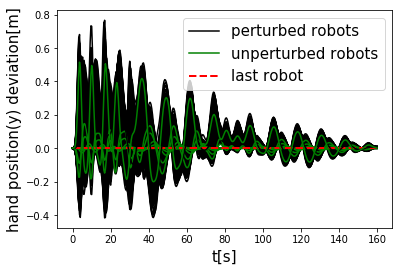

In [1845]:
for i in range(0,np.int(N/2)):#np.int(N/2) for formation with 4 followers, change to 1
    plt.plot(t[:],etotal2[i,:],'k-')
for i in range(np.int(N/2),N):#np.int(N/2) for formation with 4 followers, change to 1
    plt.plot(t[:],etotal2[i,:],'g-')
ln, = plt.plot(t[0:],etotal2[N-1,:],'r--',linewidth = 2)
ln2, = plt.plot(t[:],etotal2[0,:],'k-')
ln3, = plt.plot(t[:],etotal2[1,:],'g-')
plt.legend(handles=[ln2,ln3,ln], labels=['perturbed robots','unperturbed robots','last robot'], prop=font2, loc='best')
plt.xlabel('t[s]',font2)
plt.ylabel('hand position(y) deviation[m]',font2)
plt.savefig('/Users/apple/Desktop/figures/y_deviation_' + str(N) + '_robots.png', bbox_inches='tight')

In [1849]:
np.set_printoptions(threshold=np.inf)

In [1850]:
for i in range(0,N):
    ln, = plt.plot(yl[:,0],yl[:,1],'r--',linewidth=2)
    ln1, = plt.plot(yss[i,0:],yss[N+i,0:],'g') #with perturbation
    ln2, = plt.plot(ys[i,0:],ys[N+i,0:],'r') #without perturbation
    ln3, = plt.plot(ydd[:,i],ydd[:,N+i],'b') #desired trajectory
    plt.xlabel('x[m]',font1)
    plt.ylabel('y[m]',font1)
    plt.legend(handles=[ln,ln1,ln2,ln3], labels=['leader trajectory','with perturbation','without perturbation','desired trajectory'], prop=font3, loc='upper right')
    plt.savefig('/Users/apple/Desktop/figures/desired_solution_' + str(N) +'_robots.png', bbox_inches='tight')